In [1]:
%matplotlib inline
import numpy as np
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout, Conv2D, Conv2DTranspose
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


# Load CIFAR10 dataset

In [2]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Variational Autoencoder Parameters

In [3]:
img_rows, img_cols, img_chns = 32, 32, 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 250
latent_dim = 512
intermediate_dim = 2048
epsilon_std = 1.0
epochs = 1000
activation = 'relu'
dropout = 0.2
learning_rate = 0.0001
decay = 0.0

# Encoder Network

In [4]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [5]:
enc_filters=128
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters // 4, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
]

In [6]:
x = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x)

_z_mean_1 = Dense(latent_dim)(_enc_dense)
_z_log_var_1 = Dense(latent_dim)(_enc_dense)

z_mean = _z_mean_1
z_log_var = _z_log_var_1

# Reparameterization Trick

In [7]:
def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder Network

In [8]:
def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

In [9]:
dec_filters = 128
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    Reshape((8, 8, intermediate_dim // 64)),
    create_dec_trans_conv_layers(11, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(12, filters=dec_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=3, kernel_size=1, strides=1, activation='sigmoid'),
]

In [10]:
_dec_out = inst_layers(decoder_layers, z)
_output = _dec_out

# Loss Function

In [11]:
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

# Compile Model

In [12]:
vae = Model(inputs=x, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (250, 32, 32, 3)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (250, 32, 32, 128)    3584        input_1[0][0]                    
____________________________________________________________________________________________________
enc_bn_1 (BatchNormalization)    (250, 32, 32, 128)    512         enc_conv_1[0][0]                 
____________________________________________________________________________________________________
activation_1 (Activation)        (250, 32, 32, 128)    0           enc_bn_1[0][0]                   
___________________________________________________________________________________________

In [13]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=100)
path = "saved_models/vae-m1-checkpoint-{epoch:04d}-{loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(path,  monitor='loss', save_best_only=True, period=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01 * learning_rate)

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[TQDMNotebookCallback(), early_stopping, checkpoint, reduce_lr],
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  12506.381352901459


,loss,lr
count,455.000000,455.0000
mean,1809.251283,0.0001
std,57.865693,0.0000
min,1795.552836,0.0001
0%,1795.552836,0.0001
25%,1796.656425,0.0001
50%,1798.296198,0.0001
75%,1803.228756,0.0001
95%,1848.834777,0.0001
99%,1976.083058,0.0001


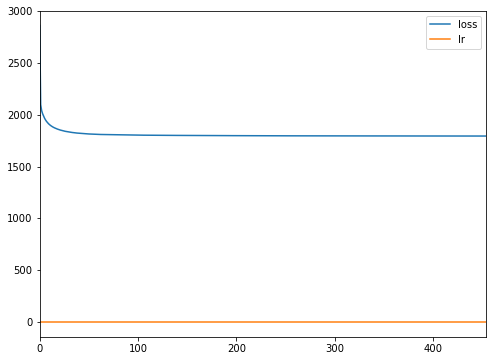

In [14]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

# Encoder Network

In [15]:
encoder = Model(x, z_mean)

# Generator Network

In [16]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

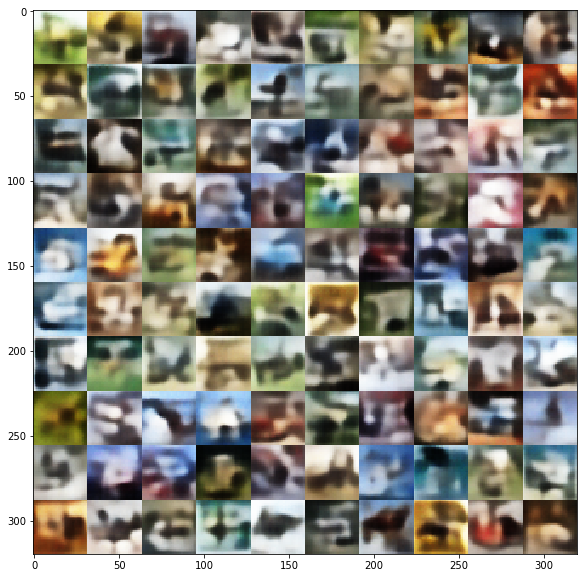

In [17]:
import matplotlib.pyplot as plt
n = 10
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, img_chns))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Save Generator Model

In [18]:
encoder_path = "saved_models/vae-m1-encoder.hdf5"
encoder.save(encoder_path)

generator_path = "saved_models/vae-m1-generator.hdf5"
generator.save(generator_path)

In [19]:
test_encoder = keras.models.load_model(encoder_path)
test_generator = keras.models.load_model(generator_path)

/home/brian/anaconda3/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
